<a href="https://colab.research.google.com/github/JMGARCIA97/TF2_GARCIA/blob/main/ANP_TF_GARCIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importacion de datos


In [59]:
import pandas as pd
import numpy as np

url = 'https://github.com/JMGARCIA97/TF2_GARCIA/raw/refs/heads/main/bank-full.csv'
df = pd.read_csv(url, sep=';')

df.head(1000)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,37,blue-collar,married,primary,no,310,yes,no,unknown,7,may,474,1,-1,0,unknown,no
996,34,admin.,married,secondary,no,475,yes,no,unknown,7,may,559,1,-1,0,unknown,no
997,43,blue-collar,married,primary,no,61,yes,no,unknown,7,may,261,1,-1,0,unknown,no
998,49,services,married,secondary,no,1377,yes,no,unknown,7,may,1101,1,-1,0,unknown,no


# Creacion columna "No llame"

In [60]:
import numpy as np

# Generar la columna 'no_llame' si aún no la tienes
p_success = 0.075
df['no_llame'] = np.random.binomial(n=1, p=p_success, size=len(df))

print("DataFrame cargado y preparado.")
print(df.head())
print("\nConteo inicial de 'default':")
print(df['no_llame'].value_counts())

DataFrame cargado y preparado.
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  \
0  unknown    5   may       261         1     -1         0  unknown  no   
1  unknown    5   may       151         1     -1         0  unknown  no   
2  unknown    5   may        76         1     -1         0  unknown  no   
3  unknown    5   may        92         1     -1         0  unknown  no   
4  unknown    5   may       198         1     -1         0  unknown  no   

   no_llame  
0         0  
1         0  
2         0  
3         0  
4  

# Analisis de calidad de datos

In [64]:
# Control del tipo de dato de cada atributo.
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [65]:
# Copia del data frame para preprocesamiento.
# Se crea una copia del data frame para evitar realizar modificaciones sobre el objeto df original.
df_preprocessed = df.copy()

In [66]:
# Recuento de valores únicos por atributo.
for col in df_preprocessed.columns:
  print(col, ":", df_preprocessed[col].nunique())

age : 77
job : 12
marital : 3
education : 4
default : 2
balance : 7168
housing : 2
loan : 2
contact : 3
day : 31
month : 12
duration : 1573
campaign : 48
pdays : 559
previous : 41
poutcome : 4
y : 2
no_llame : 2


# Perfilado de riesgo Heuristico

In [67]:
# --- Definir la clasificación de riesgo ---

# Inicializar la columna de riesgo a 0 (No Riesgoso por defecto)
df['flujo_fondos_riesgo'] = 0

# Criterio 1: Cliente en mora ('default' == 'yes')
df.loc[df['default'] == 'yes', 'flujo_fondos_riesgo'] = 1

# Criterio 2: Saldo negativo o cero
df.loc[df['balance'] <= 0, 'flujo_fondos_riesgo'] = 1

# Calcular el umbral para 'balance' bajo (primer cuartil)
umbral_balance_bajo = df['balance'].quantile(0.25)
print(f"\nUmbral de 'balance' bajo (primer cuartil): {umbral_balance_bajo:.2f}")

# Criterio 3: Saldo bajo Y con préstamos (housing o loan)
# Nota: Usamos df.loc para asegurarnos de que la asignación solo ocurra si la condición no fue cubierta antes.
# Si ya se marcó como 1 por default o saldo negativo, no es necesario volver a marcar.
df.loc[(df['flujo_fondos_riesgo'] == 0) & # Solo si no ha sido marcado como riesgo antes
       (df['balance'] < umbral_balance_bajo) &
       ((df['housing'] == 'yes') | (df['loan'] == 'yes')),
       'flujo_fondos_riesgo'] = 1

# Criterio 4: Saldo bajo Y con trabajo de posible bajo ingreso/inestabilidad
trabajos_riesgo = ['unemployed', 'student', 'retired', 'housemaid', 'self-employed'] # Ajusta esta lista según tu criterio

df.loc[(df['flujo_fondos_riesgo'] == 0) & # Solo si no ha sido marcado como riesgo antes
       (df['balance'] < umbral_balance_bajo) &
       (df['job'].isin(trabajos_riesgo)),
       'flujo_fondos_riesgo'] = 1


Umbral de 'balance' bajo (primer cuartil): 72.00


In [68]:
# --- Verificación de la clasificación ---
print("\n--- Clasificación Final de Riesgo de Flujo de Fondos ---")
print(df['flujo_fondos_riesgo'].value_counts())
print(df['flujo_fondos_riesgo'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

print("\nEjemplos de clientes Riesgosos:")
print(df[df['flujo_fondos_riesgo'] == 1][['age', 'job', 'balance', 'default', 'housing', 'loan', 'flujo_fondos_riesgo']].head(10))

print("\nEjemplos de clientes No Riesgosos:")
print(df[df['flujo_fondos_riesgo'] == 0][['age', 'job', 'balance', 'default', 'housing', 'loan', 'flujo_fondos_riesgo']].head(10))

# --- Opcional: Análisis adicional para justificar los criterios ---
print("\nAnálisis de 'balance' para clientes de riesgo vs. no riesgo:")
print(df.groupby('flujo_fondos_riesgo')['balance'].describe())

print("\nDistribución de 'default' por grupo de riesgo:")
print(pd.crosstab(df['flujo_fondos_riesgo'], df['default'], normalize='index'))

print("\nDistribución de 'job' por grupo de riesgo (top 5 para riesgo):")
print(df[df['flujo_fondos_riesgo'] == 1]['job'].value_counts(normalize=True).head())


--- Clasificación Final de Riesgo de Flujo de Fondos ---
flujo_fondos_riesgo
0    34981
1    10230
Name: count, dtype: int64
flujo_fondos_riesgo
0    77.37%
1    22.63%
Name: proportion, dtype: object

Ejemplos de clientes Riesgosos:
    age           job  balance default housing loan  flujo_fondos_riesgo
1    44    technician       29      no     yes   no                    1
2    33  entrepreneur        2      no     yes  yes                    1
7    42  entrepreneur        2     yes     yes   no                    1
12   53    technician        6      no     yes   no                    1
13   58    technician       71      no     yes   no                    1
16   45        admin.       13      no     yes   no                    1
17   57   blue-collar       52      no     yes   no                    1
18   60       retired       60      no     yes   no                    1
19   33      services        0      no     yes   no                    1
22   32   blue-collar       23     

In [69]:
# Obtener el porcentaje de cada valor en la columna 'default'
porcentaje_default = df['default'].value_counts(normalize=True)

print("Porcentaje de clientes que incurrieron en 'default':")
print(porcentaje_default)

Porcentaje de clientes que incurrieron en 'default':
default
no     0.981973
yes    0.018027
Name: proportion, dtype: float64


In [70]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,no_llame,flujo_fondos_riesgo
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0,0


# Perfilado de riesgo Regresion logistica

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


--- Entrenando el modelo de Regresión Logística ---
¡Modelo entrenado!

--- Evaluación del Modelo de Regresión Logística ---

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     10495
           1       0.75      1.00      0.86      3069

    accuracy                           0.93     13564
   macro avg       0.88      0.95      0.90     13564
weighted avg       0.94      0.93      0.93     13564


Matriz de Confusión:
[[9491 1004]
 [   1 3068]]


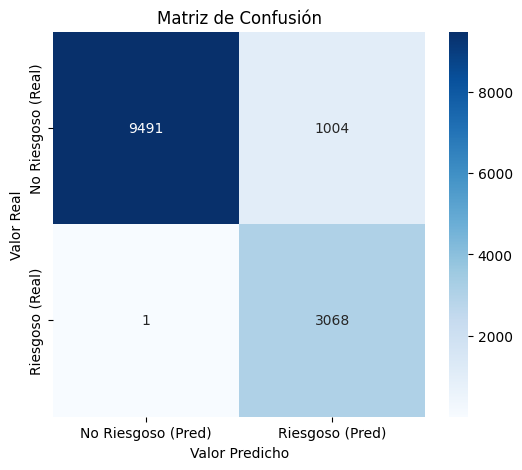


AUC-ROC Score: 0.9979


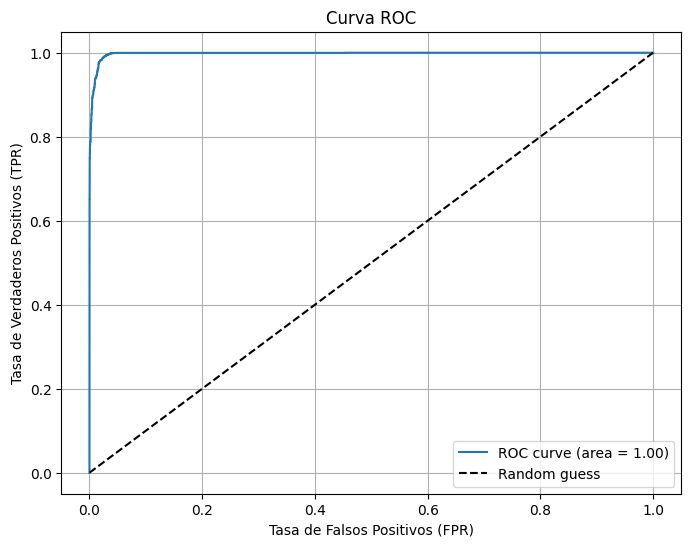


--- Coeficientes del Modelo (Importancia de Características) ---
Un coeficiente positivo alto aumenta la probabilidad de ser 'riesgoso'.
Un coeficiente negativo alto disminuye la probabilidad de ser 'riesgoso'.
              Feature  Coefficient  Absolute_Coefficient
0          job_admin.   -42.790345             42.790345
20        default_yes   -12.709449             12.709449
21         housing_no    11.374303             11.374303
22        housing_yes    -1.048326              1.048326
24           loan_yes    -0.915291              0.915291
15  education_primary    -0.607750              0.607750
28            balance    -0.531200              0.531200
3       job_housemaid    -0.461541              0.461541
26  contact_telephone    -0.442342              0.442342
25   contact_cellular    -0.419855              0.419855
10     job_unemployed    -0.419370              0.419370
4      job_management     0.403964              0.403964
2    job_entrepreneur    -0.398251             

In [72]:
# --- 4. Definir las variables predictoras (X) y la variable objetivo (y) ---
# Usaremos las mismas variables que influyeron en tu clasificación de riesgo
features = ['job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact'] # Añadí algunas más que son parte del dataset y podrían ser relevantes

target = 'flujo_fondos_riesgo'

X = df[features]
y = df[target]

# --- 5. Preprocesamiento de Datos ---
# Identificar columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Crear transformadores para el preprocesamiento
# StandardScaler para columnas numéricas
# OneHotEncoder para columnas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# --- 6. Dividir los datos en conjuntos de entrenamiento y prueba ---
# Es crucial para evaluar el modelo con datos que no ha visto
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Usamos stratify=y para asegurar que la proporción de clases de riesgo sea similar en ambos conjuntos,
# lo cual es importante si la clase de riesgo es minoritaria.

# --- 7. Crear el Pipeline del Modelo ---
# Un pipeline encadena los pasos de preprocesamiento y el modelo
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
# 'solver'='liblinear' es bueno para datasets pequeños y medianos, y maneja L1/L2
# 'class_weight'='balanced' es muy importante aquí, ya que la clase de riesgo (1) es minoritaria.
# Esto ajusta automáticamente los pesos inversamente proporcionales a las frecuencias de clase en los datos de entrada.

# --- 8. Entrenar el Modelo ---
print("\n--- Entrenando el modelo de Regresión Logística ---")
model_pipeline.fit(X_train, y_train)
print("¡Modelo entrenado!")

# --- 9. Realizar Predicciones ---
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidades de ser la clase 1 (riesgoso)

# --- 10. Evaluar el Modelo ---
print("\n--- Evaluación del Modelo de Regresión Logística ---")

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualizar la Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Riesgoso (Pred)', 'Riesgoso (Pred)'],
            yticklabels=['No Riesgoso (Real)', 'Riesgoso (Real)'])
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()


# AUC-ROC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 11. Análisis de Coeficientes (para interpretabilidad) ---
# Necesitamos acceder a los coeficientes del modelo después del OneHotEncoding
# Esto es un poco más complejo debido al pipeline

# Obtener los nombres de las características después del OneHotEncoder
feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()
feature_names.extend(numerical_cols) # Asegurarse de que los nombres numéricos estén al final, según el orden del ColumnTransformer

# Obtener los coeficientes
coefficients = model_pipeline.named_steps['classifier'].coef_[0]

# Crear un DataFrame para la interpretabilidad
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Absolute_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("\n--- Coeficientes del Modelo (Importancia de Características) ---")
print("Un coeficiente positivo alto aumenta la probabilidad de ser 'riesgoso'.")
print("Un coeficiente negativo alto disminuye la probabilidad de ser 'riesgoso'.")
print(coef_df.head(15)) # Mostrar las 15 características más influyentes

# Comparacion de modelos


In [73]:
print("\n--- COMPARACIÓN DIRECTA: Tu Heurística (REAL) vs. Regresión Logística (PREDICHO) ---")

# 1. Reporte de Clasificación
# Compara y_test (valores reales de tu heurística) con y_pred (predicciones de la Regresión Logística)
print("\nReporte de Clasificación (Regresión Logística vs. Tu Heurística):")
print(classification_report(y_test, y_pred, target_names=['No Riesgoso (0)', 'Riesgoso (1)']))


# 4. Análisis de Discrepancias (Opcional pero muy útil)
# Clientes donde la Regresión Logística predijo diferente a tu heurística
comparacion_df = pd.DataFrame({'Real_Heuristica': y_test, 'Predicho_LogReg': y_pred}, index=y_test.index)

# Casos donde tu heurística es 0, pero LogReg predice 1 (Falsos Positivos del modelo de LogReg si tu heurística es la verdad)
fp_indices = comparacion_df[(comparacion_df['Real_Heuristica'] == 0) & (comparacion_df['Predicho_LogReg'] == 1)].index
print(f"\nCasos (Falsos Positivos de LogReg): Real='No Riesgoso' por heurística, Predicho='Riesgoso' por LogReg: {len(fp_indices)} casos")
if len(fp_indices) > 0:
    print("Ejemplos de características de estos casos:")
    # Muestra las features que usaste en el modelo, y tu clasificación heurística.
    print(df.loc[fp_indices].head()[features + ['flujo_fondos_riesgo']])


# Casos donde tu heurística es 1, pero LogReg predice 0 (Falsos Negativos del modelo de LogReg)
fn_indices = comparacion_df[(comparacion_df['Real_Heuristica'] == 1) & (comparacion_df['Predicho_LogReg'] == 0)].index
print(f"\nCasos (Falsos Negativos de LogReg): Real='Riesgoso' por heurística, Predicho='No Riesgoso' por LogReg: {len(fn_indices)} casos")
if len(fn_indices) > 0:
    print("Ejemplos de características de estos casos:")
    # Muestra las features que usaste en el modelo, y tu clasificación heurística.
    print(df.loc[fn_indices].head()[features + ['flujo_fondos_riesgo']])


--- COMPARACIÓN DIRECTA: Tu Heurística (REAL) vs. Regresión Logística (PREDICHO) ---

Reporte de Clasificación (Regresión Logística vs. Tu Heurística):
                 precision    recall  f1-score   support

No Riesgoso (0)       1.00      0.90      0.95     10495
   Riesgoso (1)       0.75      1.00      0.86      3069

       accuracy                           0.93     13564
      macro avg       0.88      0.95      0.90     13564
   weighted avg       0.94      0.93      0.93     13564


Casos (Falsos Positivos de LogReg): Real='No Riesgoso' por heurística, Predicho='Riesgoso' por LogReg: 1004 casos
Ejemplos de características de estos casos:
               job   marital  education default  balance housing loan  \
42710      retired   married  secondary      no       86      no   no   
6730   blue-collar   married    primary      no      115     yes   no   
41178    housemaid  divorced  secondary      no       80      no   no   
41871      unknown    single  secondary      no    

# Verificacion de modelos (Tomando como referencia default)

In [74]:
# --- ANÁLISIS PARA LA VARIABLE PREDICHA 'y_pred_logreg' ---

print("\n--- ANÁLISIS DE LA DISTRIBUCIÓN DE 'default' POR GRUPO DE RIESGO PREDICHO ---")
print("   (Modelo de Regresión Logística)")

# Necesitamos la columna 'default' del conjunto de prueba.
# df.loc[y_test.index] asegura que obtenemos las filas originales del DataFrame
# que corresponden a los índices de X_test/y_test.
df_test_original = df.loc[y_test.index]
default_test = df_test_original['default'] # Esta es la columna 'default' real para el conjunto de prueba

# Asegúrate de que 'default_test' sea binario (0 o 1) si lo necesitas para otras comparaciones,
# pero pd.crosstab puede manejar 'yes'/'no' directamente.
# default_test_binary = (default_test == 'yes').astype(int)

# Crear la tabla de contingencia:
# Filas: La variable predicha por la Regresión Logística (0 = No Riesgoso, 1 = Riesgoso)
# Columnas: La variable 'default' real (no/yes)
# normalize='index' para obtener los porcentajes por fila (suman 1.0 a lo largo de cada fila)
distribucion_default_por_riesgo_predicho = pd.crosstab(
    index=y_pred, # Variable predicha por el modelo (clasificación de riesgo)
    columns=default_test, # Variable real de default
    normalize='index' # Normalizar por fila para ver porcentajes dentro de cada grupo predicho
)

# Renombrar el índice para mayor claridad
distribucion_default_por_riesgo_predicho.index.name = 'flujo_fondos_riesgo (Predicho por LogReg)'
distribucion_default_por_riesgo_predicho.columns.name = 'default'


print(distribucion_default_por_riesgo_predicho)

print("\n--- Interpretación ---")
print("  - La fila '0' muestra la proporción de 'default=no' y 'default=yes' para los clientes que el modelo de Regresión Logística predijo como 'No Riesgosos'.")
print("  - La fila '1' muestra la proporción de 'default=no' y 'default=yes' para los clientes que el modelo de Regresión Logística predijo como 'Riesgosos'.")
print("  - Compara estos porcentajes con los de tu tabla heurística para ver cómo el modelo de ML difiere en la concentración del riesgo real ('default').")



--- ANÁLISIS DE LA DISTRIBUCIÓN DE 'default' POR GRUPO DE RIESGO PREDICHO ---
   (Modelo de Regresión Logística)
default                                          no       yes
flujo_fondos_riesgo (Predicho por LogReg)                    
0                                          0.999895  0.000105
1                                          0.944745  0.055255

--- Interpretación ---
  - La fila '0' muestra la proporción de 'default=no' y 'default=yes' para los clientes que el modelo de Regresión Logística predijo como 'No Riesgosos'.
  - La fila '1' muestra la proporción de 'default=no' y 'default=yes' para los clientes que el modelo de Regresión Logística predijo como 'Riesgosos'.
  - Compara estos porcentajes con los de tu tabla heurística para ver cómo el modelo de ML difiere en la concentración del riesgo real ('default').


In [75]:
# --- INICIO DEL CÓDIGO PARA CREAR EL DATAFRAME DE COMPARACIÓN ---

print("\n--- Creando DataFrame de Comparación de Clasificaciones de Riesgo ---")

# Asegurarse de que tenemos el 'default' real para los mismos clientes del test set
df_test_original = df.loc[y_test.index]
default_test = df_test_original['default'].map({'no': 0, 'yes': 1}) # Convertir 'default' a 0/1 para consistencia

# Crear el DataFrame de comparación
comparacion_riesgo_df = pd.DataFrame({
    'flujo_fondos_riesgo_Heuristico': y_test,         # La clasificación de tu heurística (la "verdad")
    'flujo_fondos_riesgo_Predicho_LogReg': y_pred, # La clasificación predicha por el modelo de RL
    'default_Real': default_test                  # El estado real de default del cliente
})

# Añadir una columna para indicar si las dos clasificaciones de riesgo coinciden
comparacion_riesgo_df['Coinciden_Clasificaciones'] = (comparacion_riesgo_df['flujo_fondos_riesgo_Heuristico'] == comparacion_riesgo_df['flujo_fondos_riesgo_Predicho_LogReg']).astype(int)

# Mostrar las primeras filas del DataFrame de comparación
print("\nPrimeras 10 filas del DataFrame de Comparación:")
print(comparacion_riesgo_df.head(10))

# Mostrar un resumen de la coincidencia
coincidencia_porcentaje = comparacion_riesgo_df['Coinciden_Clasificaciones'].value_counts(normalize=True) * 100
print("\nPorcentaje de Coincidencia entre la Heurística y la Predicción de LogReg:")
print(f"Coinciden (1): {coincidencia_porcentaje.get(1, 0):.2f}%")
print(f"No Coinciden (0): {coincidencia_porcentaje.get(0, 0):.2f}%")

# También puedes analizar los casos donde NO coinciden
print("\nAnálisis de Casos Donde las Clasificaciones NO Coinciden:")
casos_no_coinciden = comparacion_riesgo_df[comparacion_riesgo_df['Coinciden_Clasificaciones'] == 0]
print(casos_no_coinciden.value_counts())


--- Creando DataFrame de Comparación de Clasificaciones de Riesgo ---

Primeras 10 filas del DataFrame de Comparación:
       flujo_fondos_riesgo_Heuristico  flujo_fondos_riesgo_Predicho_LogReg  \
31847                               0                                    0   
5470                                1                                    1   
42800                               0                                    0   
31154                               1                                    1   
10470                               0                                    0   
42710                               0                                    1   
749                                 1                                    1   
27628                               0                                    0   
34366                               0                                    0   
4274                                0                                    0   

       default_Real  

In [76]:
comparacion_riesgo_df.head()

,flujo_fondos_riesgo_Heuristico,flujo_fondos_riesgo_Predicho_LogReg,default_Real,Coinciden_Clasificaciones
31847,0,0,0,1
5470,1,1,0,1
42800,0,0,0,1
31154,1,1,0,1
10470,0,0,0,1


# Verificacion de cumplimiento ley 26.951

In [77]:
# --- Análisis de Cumplimiento/Incumplimiento de la Ley 26.951 (Simulado) ---

print("\n--- Análisis de Cumplimiento/Incumplimiento de la Ley 26.951 (Simulado) ---")

# a. Identificar contactos efectivos
# Consideramos un "contacto" si el tipo de contacto fue 'cellular' o 'telephone'
# Y la duración de la llamada fue mayor a 0 (lo que indica una conexión exitosa).
contactos_efectivos = df[(df['contact'].isin(['cellular', 'telephone'])) & (df['duration'] > 0)]
total_contactos_efectivos = len(contactos_efectivos)

print(f"1. Total de contactos telefónicos efectivos (duración > 0): {total_contactos_efectivos}")

# b. Identificar clientes que están en el registro "No Llame"
clientes_en_no_llame = df[df['no_llame'] == 1]
total_clientes_en_no_llame = len(clientes_en_no_llame)

print(f"2. Total de clientes simulados en el Registro 'No Llame' (no_llame=1): {total_clientes_en_no_llame}")
print(f"   (Esto debería ser ~25% del total del DataFrame)")

# c. Identificar posibles incumplimientos: Clientes contactados efectivamente Y en el registro "No Llame"
posibles_incumplimientos = contactos_efectivos[contactos_efectivos['no_llame'] == 1]
num_posibles_incumplimientos = len(posibles_incumplimientos)

print(f"\n3. Casos de 'posible incumplimiento': Clientes contactados efectivamente Y en 'No Llame': {num_posibles_incumplimientos}")

# d. Calcular el porcentaje de incumplimiento sobre el total de contactos efectivos
if total_contactos_efectivos > 0:
    porcentaje_incumplimiento = (num_posibles_incumplimientos / total_contactos_efectivos) * 100
    print(f"   Porcentaje de contactos efectivos que son posibles incumplimientos: {porcentaje_incumplimiento:.2f}%")
else:
    print("No hubo contactos efectivos para evaluar el cumplimiento.")


# e. Mostrar ejemplos de posibles incumplimientos
if num_posibles_incumplimientos > 0:
    print("\nEjemplos de clientes que, si el registro fuera real, estarían en incumplimiento:")
    # Se muestran columnas relevantes para entender el contexto del incumplimiento
    print(posibles_incumplimientos[['contact', 'duration', 'no_llame', 'default', 'y', 'campaign', 'poutcome']].head())
else:
    print("No se encontraron casos de posible incumplimiento en esta simulación.")

print("\n--- Nota ---")
print("Este análisis identifica el potencial de incumplimiento basado en la simulación.")
print("Las excepciones reales de la Ley 26.951 (ej. relaciones contractuales preexistentes) no se pueden verificar sin información adicional en el dataset.")


--- Análisis de Cumplimiento/Incumplimiento de la Ley 26.951 (Simulado) ---
1. Total de contactos telefónicos efectivos (duración > 0): 32189
2. Total de clientes simulados en el Registro 'No Llame' (no_llame=1): 3371
   (Esto debería ser ~25% del total del DataFrame)

3. Casos de 'posible incumplimiento': Clientes contactados efectivamente Y en 'No Llame': 2400
   Porcentaje de contactos efectivos que son posibles incumplimientos: 7.46%

Ejemplos de clientes que, si el registro fuera real, estarían en incumplimiento:
         contact  duration  no_llame default   y  campaign poutcome
12690   cellular        17         1      no  no        19  unknown
12701   cellular       149         1      no  no         5  unknown
12704   cellular       179         1      no  no         2  unknown
12705  telephone       176         1      no  no         6  unknown
12713   cellular       185         1      no  no         2  unknown

--- Nota ---
Este análisis identifica el potencial de incumplimien